# ML-ZixuanFENG-ArnaudDELOL

## 1. Préambule

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def load_usps(filename):
    with open (filename,"r") as f :
        f.readline()
        data=[[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    plt.colorbar()

5


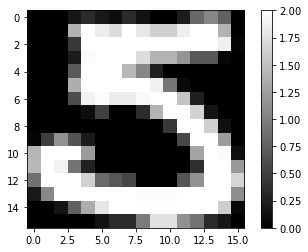

In [3]:
data_all_x,data_all_y=load_usps("./USPS/USPS_train.txt")

show_usps(data_all_x[1])
print(data_all_y[1])

In [4]:
def choose_0_1(datax,datay):
    res_x=[]
    res_y=[]
    for i in range(len(datax)):
        if datay[i]==0 or datay[i]==1:
            res_x.append(datax[i])
            res_y.append(datay[i])
    return res_x,res_y

datax,datay=choose_0_1(data_all_x,data_all_y)

In [5]:
#regression lineaire
linear=linear_model.LinearRegression()
linear.fit(datax,datay)
print("score=",linear.score(datax,datay))
#print(linear.intercept_)

w_linear=linear.coef_
print("norme=",np.linalg.norm(w_linear))
print("nb_non_null=",len(np.nonzero(w_linear)[0]))

score= 0.9844401527577691
norme= 40636267009.58993
nb_non_null= 255


Pour trouver le mieux alpha, on crée un ensemble de valeur à tester

In [6]:
alphas=np.logspace(-5,-2,200)

In [7]:
#regression ridge
ridge=linear_model.RidgeCV(alphas=alphas)
ridge.fit(datax,datay)
print("alpha=",ridge.alpha_)
print("score=",ridge.score(datax,datay))
#print(ridge.intercept_)

w_ridge=ridge.coef_
print("norme=",np.linalg.norm(w_ridge))
print("nb_non_null=",len(np.nonzero(w_ridge)[0]))

alpha= 0.01
score= 0.9844216685577594
norme= 0.6514994215590485
nb_non_null= 254


In [8]:
#algo du LASSO
lasso=linear_model.LassoCV(alphas=alphas)
lasso.fit(datax,datay)
print("alpha=",lasso.alpha_)
print("score=",lasso.score(datax,datay))
#print(lasso.intercept_)

w_lasso=lasso.coef_
print("norme=",np.linalg.norm(w_lasso))
print("nb_non_null=",len(np.nonzero(w_lasso)[0]))

alpha= 0.000344896226040576
score= 0.9828869896234311
norme= 0.17193589018122418
nb_non_null= 107


**Analyses de résultat:**<br/><br/>
***score:*** linéaire>ridge>LASSO, mais la différence n'est pas évidente<br/>
&emsp;&emsp;--> Il est facile de distinguer les 2 classes dans ce jeu de données, donc la régression linéaire a une bonne performance.<br/>
***norme du vecteur de poids:*** linéaire>>ridge>LASSO<br/>
&emsp;&emsp;--> C'est important de faire la régularisation sur la régression linéaire<br/>
***nombre de composantes non nulles:*** linéaire>ridge>>LASSO<br/>
&emsp;&emsp;--> Le vecteur de poids en utilisant l'algo de LASSO est plus "sparse".

## 2. Inpainting

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


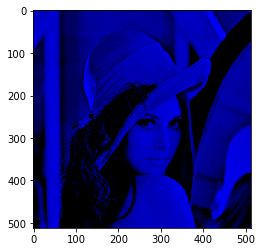

In [9]:
import matplotlib.colors as colors

def read_im(fn):
    #lire une image et de la renvoyer sous forme d’un numpy.array
    img=plt.imread(fn)
    img=img/128    

    img_hsv=colors.rgb_to_hsv(img)
    ones=np.ones(img_hsv.shape)
    img_hsv=img_hsv-ones
    
    return img_hsv
    
def show_im(im):
    #affichage de l’image (et des pixels manquants
    plt.imshow(im)

lena_hsv=read_im("./lena.jpg")
show_im(lena_hsv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
(10, 10, 3)


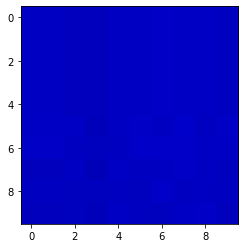

In [10]:
print(lena_hsv.shape)
l=lena_hsv[0:10,0:10,:]
print(l.shape)
plt.imshow(l)

In [11]:
def get_patch(i,j,h,im):
    #retourner le patch centré en(i,j)et de longueur h d’une image im
    return im[int(i-h/2):int(i+h/2),int(j-h/2):int(j+h/2),:]

#des fonctions de conversions entre patchs et vecteurs
def patch2vector(patch):
    h=len(patch)
    return patch.reshape((h*h*3))
    
def vector2patch(vector):
    h=int((len(vector)/3)**0.5)    
    res=np.zeros((h,h,3))
    
    for i in range(h):
        for j in range(h):
            res[i,j]=vector[(i*h+j)*3:(i*h+j+1)*3]
    return res

In [12]:
l_test=get_patch(1,1,2,lena_hsv)
print(l_test)
vec=patch2vector(l_test)
print(vec)
pat=vector2patch(vec)
print(pat)

[[[-0.98019802 -0.55309735  0.765625  ]
  [-0.98019802 -0.55309735  0.765625  ]]

 [[-0.98019802 -0.55309735  0.765625  ]
  [-0.98019802 -0.55309735  0.765625  ]]]
[-0.98019802 -0.55309735  0.765625   -0.98019802 -0.55309735  0.765625
 -0.98019802 -0.55309735  0.765625   -0.98019802 -0.55309735  0.765625  ]
[[[-0.98019802 -0.55309735  0.765625  ]
  [-0.98019802 -0.55309735  0.765625  ]]

 [[-0.98019802 -0.55309735  0.765625  ]
  [-0.98019802 -0.55309735  0.765625  ]]]


In [13]:
import random
import copy
COLOR_MISS=-100

#fonctions pour bruiter l’image originale : par exemple,
def noise(img,prc):
    #permet de supprimer au hasard un pourcentage de pixel dans l’image,
    length=len(img)
    res=copy.deepcopy(img)
    
    for i in range(length):
        for j in range(length):
            alea=random.random()
            if alea<=prc:
                res[i][j]=np.array([COLOR_MISS,COLOR_MISS,COLOR_MISS])
    return res
    
def delete_rect(img,i,j,height,width):
    #permet de supprimer tout un rectangle de l’image
    top=i-height/2
    bottom=i+height/2
    left=j-width/2
    right=j+width/2
    length=len(img)
    res=copy.deepcopy(img)
    
    for i in range(length):
        for j in range(length):
            if i>=top and i<=bottom and j>=left and j<=right:
                res[i][j]=np.array([COLOR_MISS,COLOR_MISS,COLOR_MISS])
    return res


In [169]:
#h_patch>=step
STEP=10
H_PATCH=12

def get_patch_miss(img):
    #renvoyer les patchs de l'image qui contiennent des pixels manquants
    res=[]    
    pos_i=[]
    pos_j=[]
    for i in range(int(H_PATCH/2),len(img),STEP):
        for j in range(int(H_PATCH/2),len(img),STEP):
            patch=get_patch(i,j,H_PATCH,img)
            if np.isin(COLOR_MISS,patch):
                res.append(patch2vector(patch))
                pos_i.append(i)
                pos_j.append(j)
    return np.array(res),pos_i,pos_j
    
def get_dict(img):
    #renvoyer le dictionnaire
    #i.e. les patchs qui ne contiennent aucun pixel manquant.
    res=[]    
    for i in range(int(H_PATCH/2),len(img),STEP):
        for j in range(int(H_PATCH/2),len(img),STEP):
            patch=get_patch(i,j,H_PATCH,img)
            if not np.isin(COLOR_MISS,patch):
                res.append(patch2vector(patch))
    return np.array(res)

In [161]:
def get_patch_similar(patch,dic):
    #rend le vecteur de poids sur le dictionnaire 
    #qui approxime au mieux le patch    
    indices=patch!=COLOR_MISS
    lasso=linear_model.Lasso(alpha=0.001,max_iter=5000)
    lasso.fit(dic[indices],patch[indices])
    return lasso.coef_ , lasso.predict(dic)

In [171]:
def set_patch(pos_i,pos_j,patch,img):
    res=copy.deepcopy(img)
    for i in range(H_PATCH):
        for j in range(H_PATCH):
            res[int(pos_i-H_PATCH/2+i),int(pos_j-H_PATCH/2+j)]=patch[i,j]
    return res

In [174]:
def simple_fill_img(img):
    test=copy.deepcopy(img)
    patches_miss,pos_i,pos_j=get_patch_miss(test)
    dic=get_dict(test)
    while len(patches_miss)>0:   
        #print(len(patches_miss))
        
        ind=0
        choose=False
        for i in range(len(patches_miss)):
            indices=patches_miss[i]!=COLOR_MISS
            if True in indices:
                choose=True
                ind=i
                break
                
        if choose:
            w,res=get_patch_similar(patches_miss[ind],dic.T)
            res_patch=vector2patch(res)
            test=set_patch(pos_i[ind],pos_j[ind],res_patch,test)
            patches_miss,pos_i,pos_j=get_patch_miss(test)
            dic=get_dict(test)
        else:
            return test
    return test

Test sur l'image bruité:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


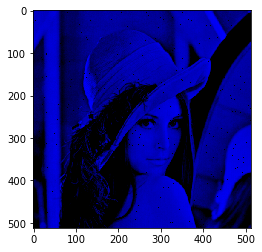

In [152]:
lena_noise=noise(lena_hsv,0.005)
show_im(lena_noise)

735
734
733
732
731
730
729
728


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15352114099963288, tolerance: 0.033375119776968463
  positive)


727


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1398809148961746, tolerance: 0.032448496658077926
  positive)


726


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.132232509303158, tolerance: 0.03146360264842795
  positive)


725


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.134805449626743, tolerance: 0.030746216061470735
  positive)


724
723


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6241066724409734, tolerance: 0.028785905578822726
  positive)


722
721


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027230984461485974, tolerance: 0.02673223014861458
  positive)


720
719
718
717
716
715


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2919886907554101, tolerance: 0.023885197680041836
  positive)


714


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4566276590257594, tolerance: 0.025531045013212815
  positive)


713


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2931642325152275, tolerance: 0.01627390886236656
  positive)


712
711
710
709
708
707


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28496939761896556, tolerance: 0.02715433397656227
  positive)


706


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10833666604989745, tolerance: 0.03204404785184329
  positive)


705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6413890111520075, tolerance: 0.03181745513768283
  positive)


704


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4443326366858642, tolerance: 0.03137310332455149
  positive)


703


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22434241466966398, tolerance: 0.030584992191475285
  positive)


702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4640722446934795, tolerance: 0.03068945930290936
  positive)


701


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24013635709286518, tolerance: 0.03106275591732218
  positive)


700


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5555714663614992, tolerance: 0.02941524929347741
  positive)


699


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4811888585986601, tolerance: 0.028758582898958163
  positive)


698


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021992563161950862, tolerance: 0.01297657063646839
  positive)


697
696
695
694


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10788450427355656, tolerance: 0.021109989167298032
  positive)


693


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44497627864813794, tolerance: 0.02433229020938019
  positive)


692
691
690
689
688
687
686
685
684


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31663758194502734, tolerance: 0.028221527453036396
  positive)


683


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6443079330295269, tolerance: 0.027852778713757756
  positive)


682


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0737974373784098, tolerance: 0.026852464171089857
  positive)


681


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26211611864046347, tolerance: 0.028336755963931978
  positive)


680


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3989535076176267, tolerance: 0.02652687953500908
  positive)


679


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0549539489076416, tolerance: 0.02660453110555095
  positive)


678


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.60183317197124, tolerance: 0.023197861195160693
  positive)


677


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8217645174620145, tolerance: 0.024773757812435016
  positive)


676


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6030057229522825, tolerance: 0.02673455752714151
  positive)


675
674
673
672
671
670


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24182611110711605, tolerance: 0.01233429212248402
  positive)


669
668
667
666
665
664
663
662
661


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8971013570205351, tolerance: 0.024387252219579356
  positive)


660


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41711117125028707, tolerance: 0.029242483531719904
  positive)


659


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08511852122137498, tolerance: 0.019739624648440906
  positive)


658


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3760024103141326, tolerance: 0.029696195569396015
  positive)


657
656


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020676806600311792, tolerance: 0.015721605891730814
  positive)


655


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1397838980407542, tolerance: 0.01918173225953488
  positive)


654
653
652
651
650
649
648
647
646


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0760570215397589, tolerance: 0.019465770234918172
  positive)


645
644
643
642
641
640
639
638


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06716391950786971, tolerance: 0.016420974744464262
  positive)


637


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4986017616161007, tolerance: 0.021584049273472714
  positive)


636


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35403526248489214, tolerance: 0.025713810301452294
  positive)


635


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06637196731136896, tolerance: 0.01621513197677965
  positive)


634


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30830581237634647, tolerance: 0.019855943465549957
  positive)


633


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36031237253200743, tolerance: 0.02676882138476902
  positive)


632


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33961929450618555, tolerance: 0.036914679707221974
  positive)


631
630


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2030845239868917, tolerance: 0.037334818295331786
  positive)


629


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06855062715401594, tolerance: 0.016228972491797167
  positive)


628


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17631714812184462, tolerance: 0.03394939711130598
  positive)


627


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04473245721765373, tolerance: 0.03517842472415366
  positive)


626
625
624


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05677847416109261, tolerance: 0.03871348760033144
  positive)


623
622
621
620
619
618
617
616
615
614
613
612
611


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29446110286838234, tolerance: 0.01712122052732015
  positive)


610


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7762496778078045, tolerance: 0.02306336053211794
  positive)


609
608


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022173234906571082, tolerance: 0.013741006872407252
  positive)


607


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6959907644635344, tolerance: 0.02417319109383471
  positive)


606


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2170350420640688, tolerance: 0.027860664681216306
  positive)


605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.051068857948560975, tolerance: 0.037550263415845664
  positive)


604
603


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07679831805465831, tolerance: 0.04461070659891426
  positive)


602
601
600
599
598


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06509507397117975, tolerance: 0.03965718876799953
  positive)


597
596
595
594
593
592
591
590
589
588


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07848897603965455, tolerance: 0.015343023264736312
  positive)


587


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09013828553170633, tolerance: 0.01828557572937401
  positive)


586


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1027617333813744, tolerance: 0.014946939776642928
  positive)


585


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49201942206166294, tolerance: 0.022396930703769802
  positive)


584


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1399767155630656, tolerance: 0.026424867709164516
  positive)


583


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7759987245411608, tolerance: 0.023379053264359587
  positive)


582


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14315083830765296, tolerance: 0.03744783168535598
  positive)


581
580
579
578
577
576
575
574
573
572
571
570


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14505943711848346, tolerance: 0.017328849950107368
  positive)


569
568
567
566
565
564
563
562
561


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08863597500641873, tolerance: 0.01915910371535612
  positive)


560


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2370638988901845, tolerance: 0.024118463819308503
  positive)


559


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16552956226170323, tolerance: 0.0224665462478775
  positive)


558


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09620899811173445, tolerance: 0.03542609744962515
  positive)


557
556
555


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06680829485168704, tolerance: 0.04553336971656894
  positive)


554
553


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05353980056191432, tolerance: 0.030672279152105547
  positive)


552
551
550
549
548
547


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053946253943703226, tolerance: 0.011945963351538115
  positive)


546
545
544
543
542
541
540
539


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45551950949869635, tolerance: 0.01612923307741174
  positive)


538


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.811268195607223, tolerance: 0.032607364076342245
  positive)


537


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5073987584457988, tolerance: 0.03679477147979177
  positive)


536


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6396321165177667, tolerance: 0.03891777448195997
  positive)


535
534
533
532
531
530
529
528
527
526


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5775580653067323, tolerance: 0.029361819302238294
  positive)


525
524
523
522
521
520
519
518
517


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32058626810664137, tolerance: 0.029365538922096347
  positive)


516
515


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3774206463499077, tolerance: 0.018943597283305823
  positive)


514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8484954283670518, tolerance: 0.027953582037171375
  positive)


513


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42328230026684466, tolerance: 0.029935591010744316
  positive)


512


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07395089595107862, tolerance: 0.03724763394555494
  positive)


511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7603601537874738, tolerance: 0.03867774056313914
  positive)


510


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28737064864864337, tolerance: 0.03831201845896337
  positive)


509


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04529060987259115, tolerance: 0.0399206404703151
  positive)


508


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11320964933241662, tolerance: 0.04065659012037129
  positive)


507


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.718440944496944, tolerance: 0.038149706381546855
  positive)


506
505
504
503


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15038844707587984, tolerance: 0.01756859791266168
  positive)


502
501
500
499
498
497
496
495
494


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033717556487037115, tolerance: 0.01733252550716078
  positive)


493


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21920657200711702, tolerance: 0.02109942542325405
  positive)


492


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7388648795549493, tolerance: 0.026506867120381163
  positive)


491


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0560716330538433, tolerance: 0.024549563953462413
  positive)


490


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3824901938181071, tolerance: 0.027214140723117453
  positive)


489


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1449557988291943, tolerance: 0.022529213290091374
  positive)


488


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09807831201559836, tolerance: 0.031159317257736668
  positive)


487
486


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048468847856472985, tolerance: 0.043710812687996044
  positive)


485


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4213110457670446, tolerance: 0.02787690093469229
  positive)


484


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1124082760410019, tolerance: 0.02222562660582514
  positive)


483
482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39333785411254496, tolerance: 0.03280767559288688
  positive)


481
480
479
478
477
476
475
474
473


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2888850213743197, tolerance: 0.018300085328489996
  positive)


472


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04411813232019668, tolerance: 0.02027788772053398
  positive)


471


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11635264461728845, tolerance: 0.01718708082113235
  positive)


470


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16738138615489007, tolerance: 0.018806066883181254
  positive)


469
468
467
466


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16411040867505022, tolerance: 0.033830424187749376
  positive)


465
464


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08023946897820622, tolerance: 0.018904493609166448
  positive)


463


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29041327361826497, tolerance: 0.024753655933514404
  positive)


462
461
460


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05490388542249036, tolerance: 0.019541699971511287
  positive)


459
458
457
456
455
454
453
452
451
450
449


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16530184300977524, tolerance: 0.01947040092545654
  positive)


448


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11088827900412745, tolerance: 0.014399424018257063
  positive)


447
446
445
444


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07648011778897601, tolerance: 0.038798319967138596
  positive)


443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03593629715946989, tolerance: 0.015662162684398007
  positive)


426
425
424
423
422
421
420
419
418
417
416
415
414
413


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1626307655719792, tolerance: 0.026441208176268566
  positive)


412


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05538016263335166, tolerance: 0.015935689287956314
  positive)


411
410
409


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015269883732715428, tolerance: 0.007594899470006428
  positive)


408


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1750556919497157, tolerance: 0.03307372547676281
  positive)


407


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8983806087697772, tolerance: 0.03745832130774611
  positive)


406
405
404
403


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18775177301507995, tolerance: 0.02697138031415267
  positive)


402
401
400
399
398
397
396
395
394


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.222632467980759, tolerance: 0.016682586603399593
  positive)


393
392
391
390
389


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2089081727234401, tolerance: 0.028361033016725316
  positive)


388


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12939628752552323, tolerance: 0.019946266044236702
  positive)


387
386
385
384


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017605757861513638, tolerance: 0.006623628068528589
  positive)


383
382
381
380
379
378


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20000539112075444, tolerance: 0.022503472479907187
  positive)


377
376


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03045916250946945, tolerance: 0.013195672652798982
  positive)


375


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21789510531895218, tolerance: 0.034822698706183916
  positive)


374
373
372
371
370
369
368


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0994893472654077, tolerance: 0.016450184870930994
  positive)


367


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1591703306054857, tolerance: 0.021720188730124775
  positive)


366
365
364
363


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7879787977904904, tolerance: 0.016252529845598437
  positive)


362
361
360
359
358


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23517613685960015, tolerance: 0.019207824012914494
  positive)


357
356
355
354
353
352
351
350
349


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009534376176791426, tolerance: 0.004984020089456573
  positive)


348


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09084424099993882, tolerance: 0.034638234062162224
  positive)


347
346


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2537243576156527, tolerance: 0.023782286309985173
  positive)


345
344


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03086376737937968, tolerance: 0.019450356895231703
  positive)


343
342
341
340


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14124426274689483, tolerance: 0.025985306607729387
  positive)


339
338
337
336


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24611727594117028, tolerance: 0.02640284305883007
  positive)


335


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.182004048306597, tolerance: 0.030208271344186917
  positive)


334
333
332
331
330
329
328
327
326
325
324
323


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01892704768716591, tolerance: 0.01603235297952613
  positive)


322


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3668926207402734, tolerance: 0.037122736093376414
  positive)


321
320


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2155640069912046, tolerance: 0.040183458916194764
  positive)


319
318


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25370785292444964, tolerance: 0.03142262071300034
  positive)


317
316
315


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15665452446708983, tolerance: 0.013549545800631467
  positive)


314
313
312
311
310


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18102297269195766, tolerance: 0.03157222428314018
  positive)


309
308
307
306
305
304
303
302
301
300
299
298


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4867270087027755, tolerance: 0.023750951870024455
  positive)


297
296


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08754450323980834, tolerance: 0.01616123767793772
  positive)


295


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2653596937892786, tolerance: 0.030460244963634614
  positive)


294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3660786174411399, tolerance: 0.03706220632208928
  positive)


293


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18477628423431014, tolerance: 0.020232106475866134
  positive)


292


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0750398273798556, tolerance: 0.039866076620090604
  positive)


291


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4111953912350401, tolerance: 0.030461416392336522
  positive)


290
289
288


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14761431353938903, tolerance: 0.014385156689097619
  positive)


287
286
285


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0789987181801397, tolerance: 0.03108995938114139
  positive)


284


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9333134371539664, tolerance: 0.026105808780939006
  positive)


283
282
281


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012372201157166529, tolerance: 0.006877875747042219
  positive)


280


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05111496923890213, tolerance: 0.042757041024226054
  positive)


279
278
277
276
275
274


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7157262692317481, tolerance: 0.02796584101496079
  positive)


273


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2420590889566121, tolerance: 0.036906814298391134
  positive)


272


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5887078352420687, tolerance: 0.026338532179639287
  positive)


271


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5342138184698992, tolerance: 0.03730122020623092
  positive)


270
269
268
267
266
265
264
263
262
261
260
259
258
257


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01868556033763724, tolerance: 0.010232554359140838
  positive)


256


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5481070510358883, tolerance: 0.023929566993678583
  positive)


255


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01607077625322262, tolerance: 0.007835641988357777
  positive)


254
253


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16141076115081177, tolerance: 0.020653312994908687
  positive)


252


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31270819640123904, tolerance: 0.03033865096267543
  positive)


251


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6449308886482861, tolerance: 0.03189343942865903
  positive)


250


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44460856407569693, tolerance: 0.034914991024243176
  positive)


249


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2081298389683255, tolerance: 0.034698664645320766
  positive)


248
247
246
245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10352759381108534, tolerance: 0.013050414772097424
  positive)


244
243
242


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09242083392454958, tolerance: 0.02949319183596848
  positive)


241
240


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.050074775495510856, tolerance: 0.04804599328346593
  positive)


239
238
237
236
235
234


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8258888432959068, tolerance: 0.023776677482395463
  positive)


233


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.258387387494011, tolerance: 0.01896647450992987
  positive)


232
231
230
229
228


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5664247511513629, tolerance: 0.022505027588866886
  positive)


227


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2915137021298868, tolerance: 0.021419659067934027
  positive)


226


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05065693770617408, tolerance: 0.022648194630300367
  positive)


225


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2490290618701927, tolerance: 0.025413435148584324
  positive)


224
223
222
221


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2506305398066857, tolerance: 0.02755262964578501
  positive)


220
219
218


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04752533212797394, tolerance: 0.0473836367254115
  positive)


217
216
215
214
213
212
211
210
209
208
207
206
205


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02228197016037825, tolerance: 0.010885178800278032
  positive)


204


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7083020687038406, tolerance: 0.03198763976343923
  positive)


203


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8822140048268245, tolerance: 0.03973384147479516
  positive)


202
201
200
199
198
197
196


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059852934069960284, tolerance: 0.029697487460081835
  positive)


195


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6774998471152323, tolerance: 0.022109484379209756
  positive)


194
193
192
191
190
189


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0285991525812328, tolerance: 0.01039134196064804
  positive)


188
187
186
185
184
183


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012640162281768452, tolerance: 0.0005369628928772108
  positive)


182
181
180
179


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21943096949498653, tolerance: 0.019327112287346855
  positive)


178


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8370856344833584, tolerance: 0.030000454680650046
  positive)


177


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08144474247096056, tolerance: 0.031659598874265386
  positive)


176


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10730050851294948, tolerance: 0.01047542742633351
  positive)


175
174
173


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30889526157752556, tolerance: 0.01995916666819623
  positive)


172


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1333722509053672, tolerance: 0.016418827031711967
  positive)


171
170
169
168
167
166
165
164


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12176341695910686, tolerance: 0.010971431403610277
  positive)


163
162
161
160
159
158


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04681744861800219, tolerance: 0.013301134632182542
  positive)


157


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4417992433512552, tolerance: 0.03150025481829643
  positive)


156
155
154
153
152


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10246815776344853, tolerance: 0.020364320298005455
  positive)


151


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10157106793789517, tolerance: 0.0294770535644569
  positive)


150


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18450526593953853, tolerance: 0.02109182216113675
  positive)


149
148
147
146
145
144


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03995693080251783, tolerance: 0.013521771899307948
  positive)


143
142
141
140
139
138
137
136
135
134


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23014502063391973, tolerance: 0.019941460708832157
  positive)


133


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25855042048511123, tolerance: 0.0337722806741128
  positive)


132


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5847942028088404, tolerance: 0.036489579605717755
  positive)


131
130
129
128
127
126
125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15648572471126698, tolerance: 0.026000965542226518
  positive)


124


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4653885522765435, tolerance: 0.019174563866868208
  positive)


123
122
121
120
119
118


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1292573911502295, tolerance: 0.01625620649448768
  positive)


117
116
115
114
113
112
111
110
109


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011030120875552996, tolerance: 0.005864776689923989
  positive)


108


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1629468975745958, tolerance: 0.015330759776192481
  positive)


107


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5768865131516172, tolerance: 0.0265060998730534
  positive)


106


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6869857096551648, tolerance: 0.03673425347919634
  positive)


105
104
103
102


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05382494225247858, tolerance: 0.05075371232882941
  positive)


101
100
99
98


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10406341414935483, tolerance: 0.02649635965781788
  positive)


97


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11560040061211652, tolerance: 0.02578216421370885
  positive)


96
95
94
93
92
91
90
89
88
87
86
85


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10831525413586007, tolerance: 0.012519421086624516
  positive)


84


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12571132989731382, tolerance: 0.013859370110387
  positive)


83


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32684904205463994, tolerance: 0.033838003055581024
  positive)


82


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26068889589122257, tolerance: 0.03825340622206127
  positive)


81
80
79


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10019776876129072, tolerance: 0.02464690077042921
  positive)


78


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29000426457067974, tolerance: 0.026168968103958794
  positive)


77
76
75


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09992664776521032, tolerance: 0.028995943954849588
  positive)


74
73
72
71
70
69
68
67
66
65


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4162701939375033, tolerance: 0.020009006799776644
  positive)


64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22299996836989422, tolerance: 0.0205225839375458
  positive)


63


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08396841417095402, tolerance: 0.03734770503118625
  positive)


62


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09120119560172313, tolerance: 0.039239067506984804
  positive)


61
60
59
58
57
56
55


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020515524131290874, tolerance: 0.0036760858934013715
  positive)


54
53
52
51
50
49


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13945940766375742, tolerance: 0.02607185957975372
  positive)


48
47
46
45
44
43
42
41
40


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023543660555761292, tolerance: 0.006474094487986334
  positive)


39


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3916670543363381, tolerance: 0.015095221936252979
  positive)


38


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10055968500767598, tolerance: 0.03785208854346777
  positive)


37
36


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05706032236232117, tolerance: 0.04013457445204582
  positive)


35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13065940371887486, tolerance: 0.03300917285507871
  positive)


14
13
12


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07131491954617708, tolerance: 0.03877259692689041
  positive)


11


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04001645323732639, tolerance: 0.039437877062748115
  positive)


10
9
8
7
6
5
4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3243066561291954, tolerance: 0.01906566874488998
  positive)


3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10245133532738038, tolerance: 0.021108723678889663
  positive)


2
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


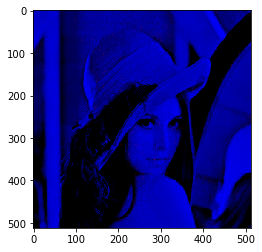

In [110]:
res_bruit=simple_fill_img(lena_noise)
show_im(res_bruit)

Test sur l'image avec un rectangle manquant:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


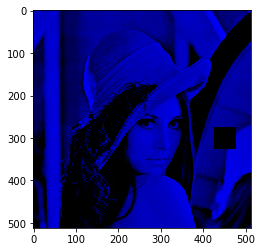

In [175]:
lena_rect=delete_rect(lena_hsv,300,450,50,50)
show_im(lena_rect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20972379925568563, tolerance: 0.011813767881894621
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07410924490708831, tolerance: 0.010168234131226396
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02209195813677145, tolerance: 0.014669725519734857
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterat

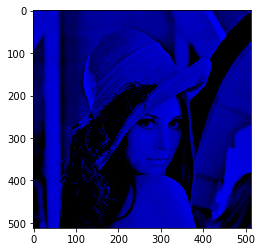

In [177]:
res_rect=simple_fill_img(lena_rect)
show_im(res_rect)

<br/><br/>

### L'ordre de remplissage est important

Dans cette section, nous allons utiliser l'ordre de remplissage proposé dans 
***A. Criminisi, P. Perez, K. ToyamaRegion Filling and Object Removal by Exemplar-Based ImageInpaintingIEEE Transaction on Image Processing (Vol 13-9), 2004***<br/>

Nous avons besoin de calculer d'abord la priorité des patchs:<br/><br/>
$$P(p)=C(p)D(p)$$<br/>
$$C(p)=\frac{\sum_{q∈Ψp∩(I−Ω)}C(q)}{|Ψp|}$$<br/>
$$D(p)=\frac{|∇I^⊥_ p ·np|}{α}$$

In [180]:
def compute_C(patch):
    indices=patch[:,:,0]!=COLOR_MISS
    return sum(indices)/len(patch)

#def compute_D(patch):
    
    
def get_priority(patch):
    return compute_C(patch)*compute_D(patch)